In [1]:
#ref https://medium.com/@mortenhegewald/marketing-channel-attribution-using-markov-chains-101-in-python-78fb181ebf1e
# https://towardsdatascience.com/marketing-channel-attribution-with-markov-chains-in-python-part-2-the-complete-walkthrough-733c65b23323
# ref https://towardsdatascience.com/multi-channel-marketing-attribution-with-markov-6b744c0b119a#:~:text=of%2067.5%25%3A-,Campaign%20attribution,rate%20without%20it%20in%20place.

# https://serhiipuzyrov.com/2019/07/markov-chain-attribution-simple-explanation-of-removal-effect/

In [2]:
import seaborn as sns

In [3]:
import pandas as pd
import numpy as np
from collections import defaultdict


pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)


df = pd.read_csv('attribution data.csv')
df = df.sort_values(['cookie', 'time'],
                    ascending=[False, True])
df['visit_order'] = df.groupby('cookie').cumcount() + 1

C:\Users\ramya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [4]:
df.head()

,cookie,time,interaction,conversion,conversion_value,channel,visit_order
586736,ooooohAFofEnonEikhAi3fF9o,2018-07-14T17:17:12Z,impression,0,0.0,Paid Search,1
586734,ooooiBh70D3k3BfAhDFfii9h7,2018-07-03T12:57:25Z,impression,0,0.0,Paid Search,1
586735,ooooiBh70D3k3BfAhDFfii9h7,2018-07-19T08:17:59Z,impression,0,0.0,Online Video,2
586731,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-06T23:30:38Z,impression,0,0.0,Online Display,1
586732,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-12T23:50:45Z,impression,0,0.0,Online Display,2


Next, we’ll want to format the data frame from long-form to wide-form, so we’ll ultimately end up with a data frame containing a single row per user and the total chronological user-journey in a list of touch-points.
We’ll do this by first grouping the chronological touch-points into a list, merging the list of final conversion/non-conversion events onto that data frame and finally adding a “Null” or “Conversion” event to the end of our user-journey lists.

In [5]:
def remove_adjacent(nums):
    i = 1
    while i < len(nums):    
        if nums[i] == nums[i-1]:
            nums.pop(i)
            i -= 1  
        i += 1
    return nums

In [6]:
df_paths = df.groupby('cookie')['channel'].aggregate(
    lambda x: (x.tolist())).reset_index()

In [7]:
df_paths.head(5)

,cookie,channel
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display, Online Display, Online Display]"
1,0000nACkD9nFkBBDECD3ki00E,"[Paid Search, Paid Search, Paid Search, Paid Search, Paid Search, Paid Search]"
2,0003EfE37E93D0BC03iBhBBhF,"[Paid Search, Paid Search, Paid Search, Paid Search, Paid Search]"
3,00073CFE3FoFCn70fBhB3kfon,[Instagram]
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search]


In [8]:
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'conversion']]
df_last_interaction.head()

,cookie,conversion
586736,ooooohAFofEnonEikhAi3fF9o,0
586735,ooooiBh70D3k3BfAhDFfii9h7,0
586733,ooooEiB0CCoEf9fiiC90Dfhfk,0
586730,ooooEBE0o0D97ACAAAnDoi3F0,0
586729,ooooE0hkAFBkED90ChDDiBFAf,0


In [9]:
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='cookie')
df_paths.head()

,cookie,channel,conversion
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display, Online Display, Online Display]",0
1,0000nACkD9nFkBBDECD3ki00E,"[Paid Search, Paid Search, Paid Search, Paid Search, Paid Search, Paid Search]",0
2,0003EfE37E93D0BC03iBhBBhF,"[Paid Search, Paid Search, Paid Search, Paid Search, Paid Search]",0
3,00073CFE3FoFCn70fBhB3kfon,[Instagram],0
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search],0


In [10]:
df_paths['path'] = np.where(
    df_paths['conversion'] == 0,
    ['Start,'] + df_paths['channel'].apply(",".join) + [',Null'],
    ['Start,'] + df_paths['channel'].apply(",".join) + [',Conversion'])
df_paths = df_paths[['cookie', 'path']]
df_paths.head()

,cookie,path
0,00000FkCnDfDDf0iC97iC703B,"Start,Instagram,Online Display,Online Display,Online Display,Null"
1,0000nACkD9nFkBBDECD3ki00E,"Start,Paid Search,Paid Search,Paid Search,Paid Search,Paid Search,Paid Search,Null"
2,0003EfE37E93D0BC03iBhBBhF,"Start,Paid Search,Paid Search,Paid Search,Paid Search,Paid Search,Null"
3,00073CFE3FoFCn70fBhB3kfon,"Start,Instagram,Null"
4,00079hhBkDF3k3kDkiFi9EFAD,"Start,Paid Search,Null"


In [11]:
df_paths["path"] = df_paths["path"].apply(lambda x : x.split(","))

In [12]:
df_paths.head()

,cookie,path
0,00000FkCnDfDDf0iC97iC703B,"[Start, Instagram, Online Display, Online Display, Online Display, Null]"
1,0000nACkD9nFkBBDECD3ki00E,"[Start, Paid Search, Paid Search, Paid Search, Paid Search, Paid Search, Paid Search, Null]"
2,0003EfE37E93D0BC03iBhBBhF,"[Start, Paid Search, Paid Search, Paid Search, Paid Search, Paid Search, Null]"
3,00073CFE3FoFCn70fBhB3kfon,"[Start, Instagram, Null]"
4,00079hhBkDF3k3kDkiFi9EFAD,"[Start, Paid Search, Null]"


#### Markov Chains

We can now move onto the actual Markov Chain method.
The algorithm for Markov Chains can be summarized in 2 steps:
 - Calculate transition probabilities between all states in our state-space
 - Calculate removal effects
 
We’ll start by defining a list of all user journeys, the number of total conversion and the base level conversion rate. All things we’ll make use of later:

In [13]:
list_of_paths = df_paths['path']
total_conversions = sum(path.count('Conversion') for path in df_paths['path'].tolist())
base_conversion_rate = total_conversions / len(list_of_paths)

In [14]:
base_conversion_rate

0.07346277508454528

In [15]:
list_of_paths[:5]

0    [Start, Instagram, Online Display, Online Display, Online Display, Null]                   
1    [Start, Paid Search, Paid Search, Paid Search, Paid Search, Paid Search, Paid Search, Null]
2    [Start, Paid Search, Paid Search, Paid Search, Paid Search, Paid Search, Null]             
3    [Start, Instagram, Null]                                                                   
4    [Start, Paid Search, Null]                                                                 
Name: path, dtype: object

Next, we’ll define a function that identifies all potential state transitions and outputs a dictionary containing these. We’ll use this as an input when calculating transition probabilities:

In [16]:
def transition_states(list_of_paths):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    transition_states = {x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}

    for possible_state in list_of_unique_channels:
        if possible_state not in ['Conversion', 'Null']:
            for user_path in list_of_paths:
                if possible_state in user_path:
                    indices = [i for i, s in enumerate(user_path) if possible_state in s]
                    for col in indices:
                        transition_states[user_path[col] + '>' + user_path[col + 1]] += 1

    return transition_states


In [17]:
trans_states = transition_states(list_of_paths)
trans_states

{'Paid Search>Paid Search': 58453,
 'Paid Search>Conversion': 4547,
 'Paid Search>Start': 0,
 'Paid Search>Online Display': 6281,
 'Paid Search>Null': 67099,
 'Paid Search>Instagram': 3431,
 'Paid Search>Facebook': 7883,
 'Paid Search>Online Video': 3746,
 'Conversion>Paid Search': 0,
 'Conversion>Conversion': 0,
 'Conversion>Start': 0,
 'Conversion>Online Display': 0,
 'Conversion>Null': 0,
 'Conversion>Instagram': 0,
 'Conversion>Facebook': 0,
 'Conversion>Online Video': 0,
 'Start>Paid Search': 76210,
 'Start>Conversion': 0,
 'Start>Start': 0,
 'Start>Online Display': 34250,
 'Start>Null': 0,
 'Start>Instagram': 28618,
 'Start>Facebook': 66848,
 'Start>Online Video': 34182,
 'Online Display>Paid Search': 5496,
 'Online Display>Conversion': 2139,
 'Online Display>Start': 0,
 'Online Display>Online Display': 24798,
 'Online Display>Null': 32473,
 'Online Display>Instagram': 1497,
 'Online Display>Facebook': 3481,
 'Online Display>Online Video': 1169,
 'Null>Paid Search': 0,
 'Null>Con

In [18]:
def transition_prob(trans_dict):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    trans_prob = defaultdict(dict)
    for state in list_of_unique_channels:
        if state not in ['Conversion', 'Null']:
            counter = 0
            index = [i for i, s in enumerate(trans_dict) if state + '>' in s]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    counter += trans_dict[list(trans_dict)[col]]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    state_prob = float((trans_dict[list(trans_dict)[col]])) / float(counter)
                    trans_prob[list(trans_dict)[col]] = state_prob

    return trans_prob


trans_prob = transition_prob(trans_states)

In [19]:
trans_prob

defaultdict(dict,
            {'Paid Search>Paid Search': 0.38598124669836237,
             'Paid Search>Conversion': 0.030025092445853142,
             'Paid Search>Online Display': 0.04147517168515584,
             'Paid Search>Null': 0.44307316428948756,
             'Paid Search>Instagram': 0.022655837295298468,
             'Paid Search>Facebook': 0.052053618594823034,
             'Paid Search>Online Video': 0.024735868991019545,
             'Start>Paid Search': 0.31739883718993117,
             'Start>Online Display': 0.14264414346877238,
             'Start>Instagram': 0.11918803205224315,
             'Start>Facebook': 0.2784080497109634,
             'Start>Online Video': 0.14236093757808985,
             'Online Display>Paid Search': 0.07735071003335538,
             'Online Display>Conversion': 0.03010428834813449,
             'Online Display>Online Display': 0.3490070792225522,
             'Online Display>Null': 0.45702503764795294,
             'Online Display>Instagra

The above should leave us with a dictionary containing all transitions and their respective transition probabilities given our historical data.
The final step is then to identify removal effects for each of our marketing channels. To do this we’ll make use of linear algebra and matrix manipulations, therefore let’s turn our above transition probabilities dictionary into a data frame (matrix):

In [20]:
def transition_matrix(list_of_paths, transition_probabilities):
    trans_matrix = pd.DataFrame()
    list_of_unique_channels = set(x for element in list_of_paths for x in element)

    for channel in list_of_unique_channels:
        trans_matrix[channel] = 0.00
        trans_matrix.loc[channel] = 0.00
        trans_matrix.loc[channel][channel] = 1.0 if channel in ['Conversion', 'Null'] else 0.0

    for key, value in transition_probabilities.items():
        origin, destination = key.split('>')
        trans_matrix.at[origin, destination] = value

    return trans_matrix


trans_matrix = transition_matrix(list_of_paths, trans_prob)

<AxesSubplot:>

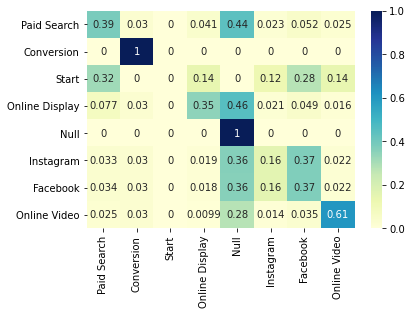

In [21]:
sns.heatmap(trans_matrix,cmap="YlGnBu",annot= True)

Using historical context and the heat map above we not only gain insights into how each marketing channel is driving users towards our conversion event, but we also gain critical information around how our marketing channels are interacting with each other. Given today’s typical multi-touch conversion journeys this information can prove to be extremely valuable and allows us to optimize our multi-channel customer journeys for conversion.
We can now iteratively go through each of our channels and assess the impact it would have on overall conversion if we were to remove a channel from our state-space. We’ll do this and add the resulting removal effects to an output dictionary:

#ref https://towardsdatascience.com/multi-channel-marketing-attribution-with-markov-6b744c0b119a#:~:text=of%2067.5%25%3A-,Campaign%20attribution,rate%20without%20it%20in%20place.

A Markov graph can be used to measure the importance of each campaign by calculating what is known as the Removal Effect. A campaign’s effectiveness is determined by removing it from the graph and simulating buyer journeys to measure the change in success rate without it in place. Removal Effect is a proxy for weight, and it’s calculated for each campaign in the Markov graph.

Using Removal Effect for marketing attribution is the final piece of the puzzle. To calculate each campaign’s attribution value we can use the following formula: A = V * (Rt / Rv)
 - A = Campaign’s attribution value
 - V = Total value to divide. For example, the total USD value of all successful buyer journeys used as input to the Markov model
 - Rt = Campaign’s Removal Effect
 - Rv = Sum of all Removal Effect values
 
Let’s walk through an example. Say that during the first quarter of the fiscal year the total USD value of all successful buyer journeys is 1M dollars. The same buyer journeys are used to build a Markov model and it calculated the Removal Effect for our Ad campaign to be 0.7 (i.e. The buyer journey success rate dropped by 70 percent when the Ad campaign was removed from the Markov graph). We know the Removal Effect values for every campaign observed in the input data, and for this example let’s say they sum to 2.8. By plugging the numbers into the formula we calculate the attribution value for our Ad campaign to be $250k:
$250,000 = $1,000,000 * (0.7 / 2.8)

In [22]:
trans_matrix

,Paid Search,Conversion,Start,Online Display,Null,Instagram,Facebook,Online Video
Paid Search,0.385981,0.030025,0.0,0.041475,0.443073,0.022656,0.052054,0.024736
Conversion,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Start,0.317399,0.000000,0.0,0.142644,0.000000,0.119188,0.278408,0.142361
Online Display,0.077351,0.030104,0.0,0.349007,0.457025,0.021069,0.048992,0.016453
Null,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000
Instagram,0.033351,0.029840,0.0,0.018683,0.363772,0.159586,0.372522,0.022247
Facebook,0.034010,0.030164,0.0,0.018197,0.363108,0.159394,0.373140,0.021987
Online Video,0.024677,0.030079,0.0,0.009894,0.280030,0.014492,0.034765,0.606062


In [23]:
def removal_effects(df, conversion_rate):
    removal_effects_dict = {}
    channels = [channel for channel in df.columns if channel not in ['Start',
                                                                     'Null',
                                                                     'Conversion']]
    for channel in channels:
        
        # dropping the channel
        removal_df = df.drop(channel, axis=1).drop(channel, axis=0)
        
        
        for column in removal_df.columns:
            row_sum = np.sum(list(removal_df.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_df.loc[column]['Null'] = null_pct
            removal_df.loc['Null']['Null'] = 1.0

        removal_to_conv = removal_df[
            ['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)
        removal_to_non_conv = removal_df.drop(
            ['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)

        removal_inv_diff = np.linalg.inv(
            np.identity(
                len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        removal_cvr = pd.DataFrame(removal_dot_prod,
                                   index=removal_to_conv.index)[[1]].loc['Start'].values[0]
        removal_effect = 1 - removal_cvr / conversion_rate
        removal_effects_dict[channel] = removal_effect

    return removal_effects_dict

In [27]:
removal_effects_dict = removal_effects(trans_matrix, base_conversion_rate)
removal_effects_dict

{'Paid Search': 0.34139431314683333,
 'Online Display': 0.1668966927245028,
 'Instagram': 0.23819930844630488,
 'Facebook': 0.413938861296829,
 'Online Video': 0.22939605439512434}

In [28]:
total_conversions

17639

In [25]:
def markov_chain_allocations(removal_effects, total_conversions):
    re_sum = np.sum(list(removal_effects.values()))

    return {k: (v / re_sum) * total_conversions for k, v in removal_effects.items()}

In [26]:
markov_chain_allocations(removal_effects_dict, total_conversions)

{'Paid Search': 4332.814054293303,
 'Online Display': 2118.173349714757,
 'Instagram': 3023.1121949450917,
 'Facebook': 5253.514914507893,
 'Online Video': 2911.3854865389553}